
[2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018)

세포의 핵을 찾는 알고리즘을 구현하는 것이 목표이다

![대체 텍스트](https://storage.googleapis.com/kaggle-media/competitions/dsb-2018/dsb.jpg)

# Index
1. library
2. data
3. function
4. segmentation models api
5. postprocessing

# library

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import os
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from textwrap import wrap
from glob import glob
from collections import Counter
from skimage.color import rgb2hsv, rgb2gray
from skimage import exposure
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tqdm
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.python.keras.utils.data_utils import Sequence
import albumentations as A
from tensorflow import keras

TensorFlow 2.x selected.


# Data

### kaggle 연동

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"podopo1130","key":"62a0e3cabdab21b32b4f7b06ddca676e"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
#permission warning 방지
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions list

ref                                                                deadline             category             reward  teamCount  userHasEntered  
-----------------------------------------------------------------  -------------------  ---------------  ----------  ---------  --------------  
digit-recognizer                                                   2030-01-01 00:00:00  Getting Started   Knowledge       2254            True  
titanic                                                            2030-01-01 00:00:00  Getting Started   Knowledge      16275            True  
house-prices-advanced-regression-techniques                        2030-01-01 00:00:00  Getting Started   Knowledge       4517            True  
connectx                                                           2030-01-01 00:00:00  Getting Started   Knowledge        372           False  
competitive-data-science-predict-future-sales                      2020-12-31 23:59:00  Playground            Kudos       5915    

In [0]:
!kaggle competitions download -c data-science-bowl-2018

 82% 65.0M/79.1M [00:01<00:00, 26.5MB/s]
100% 79.1M/79.1M [00:01<00:00, 52.9MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 89.2MB/s]
 55% 5.00M/9.10M [00:00<00:00, 16.3MB/s]
100% 9.10M/9.10M [00:00<00:00, 26.2MB/s]
 96% 265M/276M [00:06<00:00, 46.7MB/s]
100% 276M/276M [00:06<00:00, 42.4MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.68MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 126MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 114MB/s]


In [0]:
!unzip stage1_train.zip -d stage1_train
!unzip stage1_train_labels.csv.zip
!unzip stage2_test_final.zip -d stage2_test_final

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: stage2_test_final/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8/images/14ff49df48363b4f950a49c08313d933273fe9058dbda881d9579a1700e16dc8.png  
   creating: stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/
  inflating: stage2_test_final/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231/images/34d0fa5fd2fe5c9955fff299ead6ce97366a2176ad7569afc279c25ba6e0e231.png  
   creating: stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/
  inflating: stage2_test_final/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17/images/73cd786850fd7161e2b4bc557dbf6743a70cd69f511317c1546d5bb9fd326e17.png  
   creating: stage2_test_final/19699898bd07e3d27804bc52fea46d67a8d4c63ec75b5693910482855285fa90/images/
  inflating: stage2_test_final/19699898bd07e3d27804bc52fea46d67a8d4c63ec75b5693910482855285fa90/images/19699898bd07e3d27804bc52fea

In [0]:
train_data_path = "stage1_train/"
test_data_path = "stage2_test_final/"

train_ids = os.listdir(train_data_path)
# 정렬하는 이유는 제출하는 csv 파일의 아이디와 순서를 같게 하기 위해서
test_ids = sorted(os.listdir('stage2_test_final/'))

In [0]:
submission.head()

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,1 1
1,004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a7...,1 1
2,005463e6d4a0a0b21161f1d97392f22556fbddba970d94...,1 1
3,005af293e8e53218ae96746ecf9bb88b511154d4a0b35e...,1 1
4,005d47447abac7f7fa0ac56ba82f13edbf485105baf067...,1 1


In [0]:
test_ids

array(['0019c086029dd3be01f72131edb74e21ee995574e6d5c136ea868630b0d73523',
       '004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a75197dbb0be06da05cf',
       '005463e6d4a0a0b21161f1d97392f22556fbddba970d9440ae774229308a91ed',
       ...,
       'ffa053af65884b5fbe0626d350b5c3fc2e6279a5dd6fbd5c513e536eb7c23c53',
       'ffb383db5ee04d316f2e40f74649aab78648cf9b9d7fc6a7cb24b7ee95b9039c',
       'ffbc47f9b8387b12dee3dbb453a39f7e0c3348cd055896b2f12f8eb315f1c7e8'],
      dtype=object)

In [0]:
len(test_ids), len(os.listdir(test_data_path)), len(submission)

(65, 65, 65)

# Function

In [0]:
IMG_SIZE = 224
IMG_CHANNELS = 3

def read_image(id_, img_type='train'):
  img_path = 'stage1_{}/{}/images/{}.png'.format(img_type, id_, id_)
  img = skimage.io.imread(img_path)
  if img.ndim != 3: # 사진중에 채널이 0인 이미지가 있어서 수정하기 위한 것
    img = fix_image(img) 
  img = img[:,:,:3] # 원본 이미지는 4채널인데 rgb 3채널만 쓴다.(4번째 채널은 alpha 값이다)
  return img

def read_test_image(id_):
  img_path = test_data_path+'{}/images/{}.png'.format(id_, id_)
  img = skimage.io.imread(img_path)
  if img.ndim != 3:
    img = fix_image(img)
  else: 
    img = img[:,:,:3]
  
  return img

def read_images(id_list):
  images = []
  masks = []
  for id_ in id_list:
    image = read_image(id_)
    images.append(image.astype(np.uint8))
    mask = read_mask(id_)
    masks.append(mask.astype(np.float16))

  return images, masks

def read_test_images(id_list):
  images = []
  for id_ in id_list:
    image = read_test_image(id_)
    images.append(image.astype(np.uint8))
  return images

def fix_image(image):
  # 이미지의 픽셀값을 0에서 255로 값을 정규화한다.
  norm_image = cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  color_image = skimage.color.gray2rgb(norm_image).astype(np.uint8)
  return color_image


def read_mask(id_):
  mask_path = train_data_path+'{}/masks/*.png'.format(id_)
  mask = skimage.io.imread_collection(mask_path).concatenate()
  mask = np.sum(mask, axis=0)
  mask = np.expand_dims(mask, axis=-1)
  return mask

def read_image_mask(id_):
  return read_image(id_), read_mask(id_)

def resize_train(id_list): # return resized images, masks
  images = np.zeros((len(id_list), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)
  labels = np.zeros((len(id_list), IMG_SIZE, IMG_SIZE, 1), dtype=np.bool)

  for n, id_ in enumerate(id_list):
    img = read_image(id_)
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    images[n] = img

    mask = read_mask(id_)
    mask = resize(mask, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    labels[n] = mask

  return images, labels


def resize_test(id_list): # return resized images

  images = np.zeros((len(id_list), IMG_SIZE, IMG_SIZE, IMG_CHANNELS), dtype=np.uint8)

  for n, id_ in enumerate(id_list):
    img = read_test_image(id_)
    img = resize(img, (IMG_SIZE, IMG_SIZE), mode='constant', preserve_range=True)
    images[n] = img
  return images 

def dim_check(id_list):
  not_4_dim = []
  for n, id_ in enumerate(id_list):
    img_path = test_data_path+'{}/images/{}.png'.format(id_, id_)
    img = skimage.io.imread(img_path)
    if img.ndim != 3:
      not_4_dim.append(n)
  return not_4_dim

In [0]:
# U-Net에 넣기 위하여 모든 이미지 크기를 맞춰준다.
x_train, y_train = resize_train(train_ids)
x_test = resize_test(test_ids)

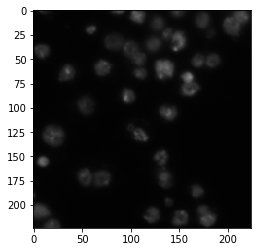

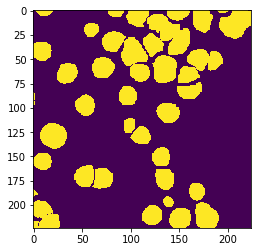

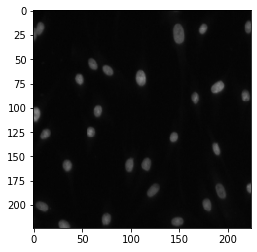

In [0]:
i = random.randint(0, 31)
plt.imshow(x_train[i])
plt.show()
plt.imshow(y_train[i,:,:,0])
plt.show()
plt.imshow(x_test[i])

# segmentation models api

In [0]:
!pip install segmentation-models

In [0]:
import segmentation_models
segmentation_models.set_framework('tf.keras')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [0]:
segmentation_models.framework()

'tf.keras'

In [0]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss, dice_loss, bce_dice_loss, binary_crossentropy
from segmentation_models.metrics import iou_score

In [0]:
BACKBONE = 'resnet101' # unet 구조를 어떤 모델로 할 것인지
preprocess_input = get_preprocessing(BACKBONE)

In [0]:
train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size=0.1) # 훈련용 데이터에서 검증용 데이터 만들기

In [0]:
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((603, 224, 224, 3), (67, 224, 224, 3), (603, 224, 224, 1), (67, 224, 224, 1))

In [0]:
train_x = preprocess_input(train_x)
train_y = train_y.astype(np.float16)

val_x = preprocess_input(val_x)
val_y = val_y.astype(np.float16)

[library API](https://segmentation-models.readthedocs.io/en/latest/api.html)

### model

In [0]:
# define model
# decoder_filters=(256, 128, 64, 32, 16) 파라미터로 디코더 부분의 컨볼루션 특징맵 개수를 지정할 수 있다.
# class : a number of classes for output (output shape - (h, w, classes))
# activation : 출력이 나오기 전 층의 활성화 함수
# encoder_freeze : True 로 설정하면 인코더 부분은 이미 imagenet으로 훈련된 모델의 가중치를 사용한다.
# decoder_use_batchnorm : True 로 설정하면 conv2d 층과 Activation layer 층 사이에 BatchNormalisation 층을 추가한다.
model = Unet(BACKBONE, encoder_weights='imagenet',
             classes=1, activation='sigmoid', encoder_freeze=True,
             decoder_use_batchnorm=True)
# model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.compile('Adam', loss=binary_crossentropy, metrics=[iou_score])

171171840/171164896 [==============================] - 11s 0us/step


### train version 1

In [0]:
train_gen = ImageDataGenerator(
    horizontal_flip=True
)

train_gen.fit(train_x)

a = train_gen.flow(train_x, train_y, batch_size=64)

epochs = 1
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in a:
        x_batch = preprocess_input(x_batch)
        model.fit(x_batch, y_batch, epochs=10, verbose=1)
        batches += 1
        if batches >= len(train_x) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

### train version 2

In [0]:
model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=10
)

Train on 603 samples
Epoch 1/10
603/603 [==============================] - 24s 41ms/sample - loss: 1.3876 - iou_score: 0.2187
Epoch 2/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.8886 - iou_score: 0.3913
Epoch 3/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.5654 - iou_score: 0.5819
Epoch 4/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.4104 - iou_score: 0.6977
Epoch 5/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.3409 - iou_score: 0.7526
Epoch 6/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.3186 - iou_score: 0.7738
Epoch 7/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.2917 - iou_score: 0.7942
Epoch 8/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.2689 - iou_score: 0.8108
Epoch 9/10
603/603 [==============================] - 6s 10ms/sample - loss: 0.2616 - iou_score: 0.8173
Epoch 10/10
603/603 [=====================

### train version 3

In [0]:
class TrainGenerator(Sequence):

  def __init__(self, x, y, batch_size, augmentation):
    self.x, self.y = x, y
    self.batch_size = batch_size
    self.augment = augmentation

  def __len__(self):
    return int(np.ceil(len(self.x)/float(self.batch_size)))
  
  def __getitem__(self, idx):
    batch_x = self.x[idx*self.batch_size:(idx+1)*self.batch_size]
    batch_y = self.y[idx*self.batch_size:(idx+1)*self.batch_size]
    batch_x = np.stack([self.augment(image=x)['image'].astype(np.uint8) for x in batch_x], axis=0)
    batch_y = np.array(batch_y).astype(np.float16)
    batch_x = preprocess_input(batch_x)
    return batch_x, batch_y

t = A.Compose([
    A.RandomBrightnessContrast(), 
    A.ChannelShuffle(True),   
    A.RandomGamma(),    
    A.CLAHE(),
    # A.HorizontalFlip(),
    # A.VerticalFlip(),
    A.IAASharpen(),
    A.RandomContrast(),
    # A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=1),
    # A.IAAEmboss(), 
    # A.Blur(blur_limit=3)
], p=1)

v = A.Compose([
    A.ChannelShuffle(True),
    A.RandomGamma(),
    A.CLAHE(),
    A.RandomContrast()
])

In [0]:
# dice_loss
train_gen = TrainGenerator(train_x, train_y, batch_size=32, augmentation=t)
test_gen = TrainGenerator(val_x, val_y, batch_size=32, augmentation=v)
history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 3 steps
Epoch 1/20
19/19 [==============================] - 27s 1s/step - loss: 0.3075 - iou_score: 0.2702 - val_loss: 1.4706 - val_iou_score: 0.0946
Epoch 2/20
19/19 [==============================] - 7s 359ms/step - loss: 0.1476 - iou_score: 0.5133 - val_loss: 4.6067 - val_iou_score: 0.1581
Epoch 3/20
19/19 [==============================] - 7s 358ms/step - loss: 0.1156 - iou_score: 0.6174 - val_loss: 1.4428 - val_iou_score: 0.1665
Epoch 4/20
19/19 [==============================] - 7s 358ms/step - loss: 0.0967 - iou_score: 0.6756 - val_loss: 0.2561 - val_iou_score: 0.3368
Epoch 5/20
19/19 [==============================] - 7s 359ms/step - loss: 0.0906 - iou_score: 0.7011 - val_loss: 0.1851 - val_iou_score: 0.4641
Epoch 6/20
19/19 [==============================] - 7s 359ms/step - loss: 0.0857 - iou_score: 0.7226 - val_loss: 0.

In [0]:
# bce dice loss
train_gen = TrainGenerator(train_x, train_y, batch_size=32, augmentation=t)
test_gen = TrainGenerator(val_x, val_y, batch_size=32, augmentation=v)
history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 3 steps
Epoch 1/20
19/19 [==============================] - 19s 991ms/step - loss: 0.9186 - iou_score: 0.3165 - val_loss: 7.6371 - val_iou_score: 0.1958
Epoch 2/20
19/19 [==============================] - 7s 365ms/step - loss: 0.4566 - iou_score: 0.5477 - val_loss: 11.2821 - val_iou_score: 0.1991
Epoch 3/20
19/19 [==============================] - 7s 365ms/step - loss: 0.3195 - iou_score: 0.6634 - val_loss: 5.3575 - val_iou_score: 0.2117
Epoch 4/20
19/19 [==============================] - 7s 366ms/step - loss: 0.2773 - iou_score: 0.7107 - val_loss: 1.2019 - val_iou_score: 0.2493
Epoch 5/20
19/19 [==============================] - 7s 367ms/step - loss: 0.2500 - iou_score: 0.7367 - val_loss: 0.7200 - val_iou_score: 0.4233
Epoch 6/20
19/19 [==============================] - 7s 366ms/step - loss: 0.2331 - iou_score: 0.7587 - val_loss: 0.5012 - val_iou_score: 0.5714
Epoch 7/20
19/19 [=========================

In [0]:
# binary cross entropy
train_gen = TrainGenerator(train_x, train_y, batch_size=32, augmentation=t)
test_gen = TrainGenerator(val_x, val_y, batch_size=32, augmentation=v)
history = model.fit_generator(train_gen, epochs=20, validation_data=test_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 3 steps
Epoch 1/20
19/19 [==============================] - 18s 946ms/step - loss: 0.4534 - iou_score: 0.2223 - val_loss: 31.7845 - val_iou_score: 0.0036
Epoch 2/20
19/19 [==============================] - 7s 365ms/step - loss: 0.2050 - iou_score: 0.4298 - val_loss: 10.9276 - val_iou_score: 0.0126
Epoch 3/20
19/19 [==============================] - 7s 367ms/step - loss: 0.1442 - iou_score: 0.5413 - val_loss: 6.8583 - val_iou_score: 0.0368
Epoch 4/20
19/19 [==============================] - 7s 366ms/step - loss: 0.1147 - iou_score: 0.6171 - val_loss: 3.1463 - val_iou_score: 0.1156
Epoch 5/20
19/19 [==============================] - 7s 365ms/step - loss: 0.1013 - iou_score: 0.6642 - val_loss: 0.3419 - val_iou_score: 0.4172
Epoch 6/20
19/19 [==============================] - 7s 364ms/step - loss: 0.0922 - iou_score: 0.6925 - val_loss: 0.3689 - val_iou_score: 0.4463
Epoch 7/20
19/19 [========================

### predict

In [0]:
# 테스트 데이터 예측
predict = model.predict(x_test)
predict = np.squeeze(predict)
predict.shape

(3019, 224, 224)

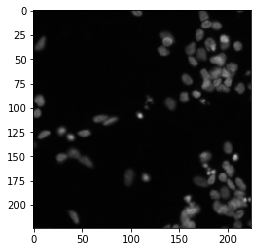

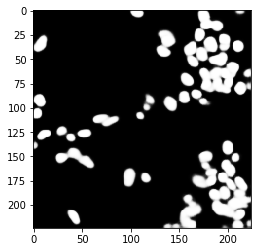

In [0]:
# 예측값 확인
i = random.randint(0, len(predict)-1)

plt.imshow(x_test[i])
plt.show()
plt.imshow(predict[i], cmap='gray')
plt.show()

# postprocessing

### resize mask to orginal size

In [0]:
resized_masks = []
for n, id_ in enumerate(test_ids):
  image = read_test_image(id_)
  h, w = image.shape[0], image.shape[1]
  resized = resize(predict[n], (h, w), mode='constant', preserve_range=True)
  resized = np.where(resized>0.5, 1, 0).astype(np.bool)
  resized_masks.append(resized)

In [0]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

In [0]:
rle = list(map(rle_encoding, resized_masks))

In [0]:
submission.head(10)

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,1 1
1,004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a7...,1 1
2,005463e6d4a0a0b21161f1d97392f22556fbddba970d94...,1 1
3,005af293e8e53218ae96746ecf9bb88b511154d4a0b35e...,1 1
4,005d47447abac7f7fa0ac56ba82f13edbf485105baf067...,1 1
5,00ac87390253a22f6eb67c5771a73050e06200d1aa682f...,1 1
6,00b4b9c026cfc91af21691503bad67081fc02d5c77b3cd...,1 1
7,00da4fe5346bbb36ccf178964a22fdf7e3388898962417...,1 1
8,00e36f2470960e84cfc9f0d30c1f76abd7b35e4516380b...,1 1
9,00e67980783eaae30d41f6479beb9c04eb91de46085376...,1 1


In [0]:
submission['EncodedPixels'] = rle

In [0]:
submission.head()

,ImageId,EncodedPixels
0,0019c086029dd3be01f72131edb74e21ee995574e6d5c1...,"[129, 14, 385, 14, 641, 14, 898, 12, 1155, 10,..."
1,004a078bb44ee55ee7d6f1c19f96b3a0d3b5037746a3a7...,"[119, 11, 146, 16, 195, 57, 374, 12, 402, 16, ..."
2,005463e6d4a0a0b21161f1d97392f22556fbddba970d94...,"[1, 11, 66, 19, 101, 17, 232, 1, 248, 6, 257, ..."
3,005af293e8e53218ae96746ecf9bb88b511154d4a0b35e...,"[45, 10, 75, 22, 361, 154, 556, 66, 656, 22, 8..."
4,005d47447abac7f7fa0ac56ba82f13edbf485105baf067...,"[3896, 7, 3926, 4, 4471, 6, 5045, 6, 5620, 4, ..."


In [0]:
submission.to_csv('test05.csv', index=False)